이 노트북은 [케라스 창시자에게 배우는 딥러닝 2판](https://tensorflow.blog/kerasdl2/)의 예제 코드를 담고 있습니다.

이 노트북은 텐서플로 2.9 버전에서 테스트했습니다.

<table align="left">
    <tr>
        <td>
            <a href="https://colab.research.google.com/github/rickiepark/deep-learning-with-python-2nd/blob/main/chapter10_dl-for-timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
        </td>
    </tr>
</table>

In [1]:
# 실행마다 동일한 결과를 얻기 위해 케라스에 랜덤 시드를 사용하고 텐서플로 연산을 결정적으로 만듭니다. 
import tensorflow as tf

tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

# 시계열을 위한 딥러닝

## 다양한 종류의 시계열 작업

## 기온 예측 문제

In [2]:
!wget -O jena_climate_2009_2016.csv.zip https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip -f jena_climate_2009_2016.csv.zip

--2022-05-20 11:04:16--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.48.222
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.48.222|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: 'jena_climate_2009_2016.csv.zip'

jena_climate_2009_2 100%[===================>]  12.94M  67.5MB/s    in 0.2s    

2022-05-20 11:04:16 (67.5 MB/s) - 'jena_climate_2009_2016.csv.zip' saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip


**예나 날씨 데이터셋 조사하기**

In [3]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


**데이터 파싱**

In [4]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

**전체 기온을 그래프로 그리기**

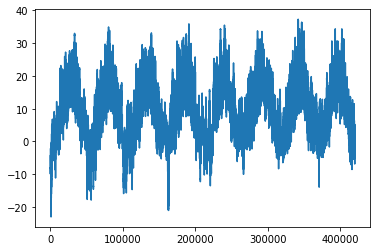

In [5]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)
plt.show()

**처음 10일간의 기온을 그래프로 그리기**

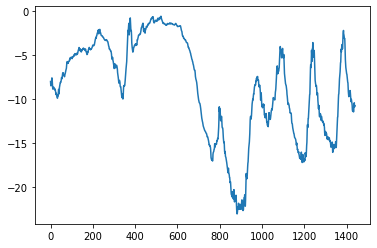

In [6]:
plt.plot(range(1440), temperature[:1440])
plt.show()

**각 분할에 사용할 샘플 수 계산하기**

In [7]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


### 데이터 준비

**데이터 정규화**

In [8]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [9]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


2022-05-20 11:04:21.155306: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


**훈련, 검증, 테스트 데이터셋 만들기**

In [10]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

**훈련 데이터셋의 배치 크기 확인하기**

In [11]:
for samples, targets in train_dataset:
    print("샘플 크기:", samples.shape)
    print("타깃 크기:", targets.shape)
    break

샘플 크기: (256, 120, 14)
타깃 크기: (256,)


### 상식 수준의 기준점

**상식적인 기준 모델의 MAE 계산하기**

In [12]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"검증 MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"테스트 MAE: {evaluate_naive_method(test_dataset):.2f}")

검증 MAE: 2.44
테스트 MAE: 2.62


### 기본적인 머신 러닝 모델 시도해 보기

**밀집 연결 모델 훈련하고 평가하기**

In [13]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"테스트 MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 24s 29ms/step - loss: 11.6264 - mae: 2.6461 - val_loss: 10.8365 - val_mae: 2.5861
Epoch 2/10
819/819 [==============================] - 24s 29ms/step - loss: 8.6998 - mae: 2.3202 - val_loss: 10.4282 - val_mae: 2.5323
Epoch 3/10
819/819 [==============================] - 24s 29ms/step - loss: 8.0889 - mae: 2.2358 - val_loss: 11.4746 - val_mae: 2.6917
Epoch 4/10
819/819 [==============================] - 24s 29ms/step - loss: 7.7212 - mae: 2.1845 - val_loss: 10.3349 - val_mae: 2.5274
Epoch 5/10
819/819 [==============================] - 24s 29ms/step - loss: 7.4277 - mae: 2.1428 - val_loss: 11.4727 - val_mae: 2.6663
Epoch 6/10
819/819 [==============================] - 24s 29ms/step - loss: 7.2154 - mae: 2.1113 - val_loss: 10.5074 - val_mae: 2.5567
Epoch 7/10
819/819 [==============================] - 24s 29ms/step - loss: 7.0305 - mae: 2.0840 - val_loss: 11.2407 - val_mae: 2.6607
Epoch 8/10
819/819 [==============================] - 

**결과 그래프 그리기**

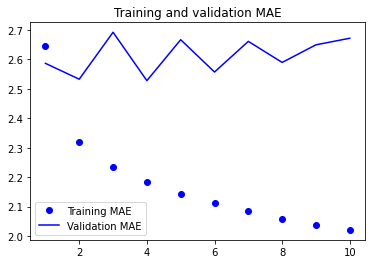

In [14]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### 1D 합성곱 모델 시도해 보기

In [15]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"테스트 MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 43s 51ms/step - loss: 22.7543 - mae: 3.7213 - val_loss: 16.2358 - val_mae: 3.1797
Epoch 2/10
819/819 [==============================] - 42s 51ms/step - loss: 15.7480 - mae: 3.1554 - val_loss: 14.7094 - val_mae: 3.0265
Epoch 3/10
819/819 [==============================] - 42s 51ms/step - loss: 14.5590 - mae: 3.0285 - val_loss: 14.7361 - val_mae: 3.0102
Epoch 4/10
819/819 [==============================] - 43s 52ms/step - loss: 13.6145 - mae: 2.9231 - val_loss: 15.7775 - val_mae: 3.1129
Epoch 5/10
819/819 [==============================] - 43s 52ms/step - loss: 12.8796 - mae: 2.8400 - val_loss: 21.4148 - val_mae: 3.7262
Epoch 6/10
819/819 [==============================] - 43s 52ms/step - loss: 12.3221 - mae: 2.7762 - val_loss: 17.4620 - val_mae: 3.2780
Epoch 7/10
819/819 [==============================] - 43s 52ms/step - loss: 11.8587 - mae: 2.7224 - val_loss: 16.7707 - val_mae: 3.2036
Epoch 8/10
819/819 [============================

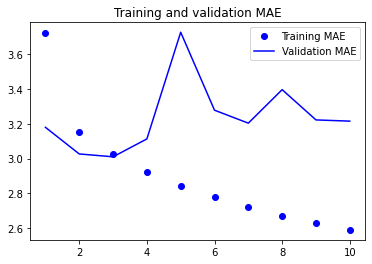

In [16]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### 첫 번째 순환 신경망

**간단한 LSTM 기반 모델**

In [17]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"테스트 MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 77s 92ms/step - loss: 45.6244 - mae: 4.9473 - val_loss: 13.4015 - val_mae: 2.7692
Epoch 2/10
819/819 [==============================] - 76s 92ms/step - loss: 11.3425 - mae: 2.6031 - val_loss: 9.5202 - val_mae: 2.3988
Epoch 3/10
819/819 [==============================] - 75s 92ms/step - loss: 9.8059 - mae: 2.4357 - val_loss: 9.4580 - val_mae: 2.3970
Epoch 4/10
819/819 [==============================] - 75s 92ms/step - loss: 9.2082 - mae: 2.3598 - val_loss: 9.6457 - val_mae: 2.4073
Epoch 5/10
819/819 [==============================] - 75s 92ms/step - loss: 8.8096 - mae: 2.3102 - val_loss: 9.2474 - val_mae: 2.3641
Epoch 6/10
819/819 [==============================] - 79s 96ms/step - loss: 8.5577 - mae: 2.2793 - val_loss: 9.0858 - val_mae: 2.3463
Epoch 7/10
819/819 [==============================] - 85s 103ms/step - loss: 8.3365 - mae: 2.2487 - val_loss: 9.5327 - val_mae: 2.4066
Epoch 8/10
819/819 [==============================] - 85s 

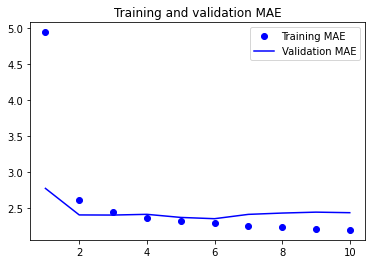

In [18]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

## 순환 신경망 이해하기

**넘파이로 구현한 간단한 RNN**

In [19]:
import numpy as np
timesteps = 100
input_features = 32
output_features = 64
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t
final_output_sequence = np.stack(successive_outputs, axis=0)

### 케라스의 순환 층

**어떤 길이의 시퀀스도 처리할 수 있는 RNN 층**

In [20]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

**마지막 출력 스텝만 반환하는 RNN 층**

In [21]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)

(None, 16)


**전체 출력 시퀀스를 반환하는 RNN 층**

In [22]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)

(None, 120, 16)


**스태킹(stacking) RNN 층**

In [23]:
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)

## 순환 신경망의 고급 사용법

### 과대적합을 감소하기 위해 순환 드롭아웃 사용하기

**드롭아웃 규제를 적용한 LSTM 모델 훈련하고 평가하기**

In [24]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/50
819/819 [==============================] - 128s 153ms/step - loss: 29.3529 - mae: 3.9858 - val_loss: 9.7376 - val_mae: 2.4057
Epoch 2/50
819/819 [==============================] - 127s 154ms/step - loss: 14.7353 - mae: 2.9750 - val_loss: 9.4424 - val_mae: 2.3749
Epoch 3/50
819/819 [==============================] - 127s 154ms/step - loss: 13.7420 - mae: 2.8733 - val_loss: 9.1656 - val_mae: 2.3420
Epoch 4/50
819/819 [==============================] - 126s 154ms/step - loss: 13.2093 - mae: 2.8163 - val_loss: 9.2651 - val_mae: 2.3561
Epoch 5/50
819/819 [==============================] - 137s 167ms/step - loss: 12.6281 - mae: 2.7551 - val_loss: 9.3118 - val_mae: 2.3647
Epoch 6/50
819/819 [==============================] - 138s 168ms/step - loss: 12.3086 - mae: 2.7166 - val_loss: 9.1853 - val_mae: 2.3445
Epoch 7/50
819/819 [==============================] - 138s 168ms/step - loss: 12.0157 - mae: 2.6840 - val_loss: 9.2151 - val_mae: 2.3654
Epoch 8/50
819/819 [=====================

KeyboardInterrupt: 

In [ ]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [ ]:
inputs = keras.Input(shape=(sequence_length, num_features))
x = layers.LSTM(32, recurrent_dropout=0.2, unroll=True)(inputs)

### 스태킹 순환 층

**드롭아웃 규제와 스태킹을 적용한 GRU 모델을 훈련하고 평가하기**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"테스트 MAE: {model.evaluate(test_dataset)[1]:.2f}")

In [ ]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### 양방향 RNN 사용하기

시퀀스를 거꾸로 뒤집어 LSTM 모델 훈련하기 (책에는 없음)

In [ ]:
def train_generator():
    while True:
        for samples, targets in train_dataset:
            yield samples[:, ::-1, :], targets

def val_generator():
    while True:
        for samples, targets in val_dataset:
            yield samples[:, ::-1, :], targets
        
train_gen = train_generator()
val_gen = val_generator()

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_gen,
                    epochs=10,
                    steps_per_epoch=819,
                    validation_data=val_gen,
                    validation_steps=410)

In [ ]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

**양방향 LSTM 모델 훈련하고 평가하기**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)

### 더 나아가서

## 요약